In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from utils.dataset import get_dataloaders
from utils.metrics import evaluate_model  # Ensure it returns: report, accuracy, matrix

from models.vgg import CustomVGG
from models.resnet import CustomResNet
from models.mobilenet import CustomMobileNet
from models.inception import CustomInception
from models.densenet import CustomDenseNet

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [2]:
data_dir = r'Pets\Master Folder'
train_loader, val_loader, class_names = get_dataloaders(data_dir)
num_classes = len(class_names)


In [3]:
model_map = {
    'vgg': CustomVGG,
    'resnet': CustomResNet,
    'mobilenet': CustomMobileNet,
    'inception': CustomInception,
    'densenet': CustomDenseNet
}



A dictionary that maps model names  to custom model classes enabling looping through multiple architectures 

In [4]:
def train_and_evaluate_model(model_name, model_class, num_classes, device, 
                             train_loader, val_loader, class_names, epochs=10, lr=1e-3):
    print(f"\n==== Training {model_name.upper()} model ====")
    model = model_class(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_acc = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        print(f"\nEpoch [{epoch+1}/{epochs}] - Training Loss: {avg_loss:.4f}")

        # Evaluation
        report, accuracy, matrix = evaluate_model(model, val_loader, device, class_names)
        val_accuracies.append(accuracy)

        print("\nValidation Classification Report:\n", report)
        print("\nConfusion Matrix:")
        print(matrix)

        # Plot confusion matrix for each epoch
        plot_confusion_matrix(matrix, class_names, f"{model_name} - Epoch {epoch+1}")

        # Save best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')
            print(f"New best model saved (Accuracy: {best_acc:.4f})")

        scheduler.step()

    # Plot final training loss and accuracy
    plot_training_curves(train_losses, val_accuracies, model_name)

    # Print final accuracy
    print(f"\nTraining complete. Best validation accuracy: {best_acc:.4f}\n")

    del model
    torch.cuda.empty_cache()
    return best_acc


def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


def plot_training_curves(train_losses, val_accuracies, model_name):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', color='blue', label='Training Loss')
    plt.title(f"{model_name.upper()} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, marker='x', color='green', label='Validation Accuracy')
    plt.title(f"{model_name.upper()} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Trains a specified model architecture using cross-entropy loss and Adam optimizer.
Applies learning rate decay every 5 epochs using StepLR.
Evaluates the model on the validation set after each epoch using evaluate_model.
Tracks training loss and validation accuracy.
Plots the confusion matrix for each epoch.
Saves the best model based on validation accuracy

Iteratively trains and evaluates each model (VGG, ResNet, etc.).
Tracks validation accuracy.
Identifies and logs the best model architecture


==== Training VGG model ====

Epoch [1/10] - Training Loss: 5.4339

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2941    1.0000    0.4545        10
       happy     1.0000    0.0909    0.1667        11

    accuracy                         0.3056        36
   macro avg     0.3235    0.2727    0.1553        36
weighted avg     0.3873    0.3056    0.1772        36


Confusion Matrix:
[[ 0  0  9  0]
 [ 0  0  6  0]
 [ 0  0 10  0]
 [ 0  1  9  1]]


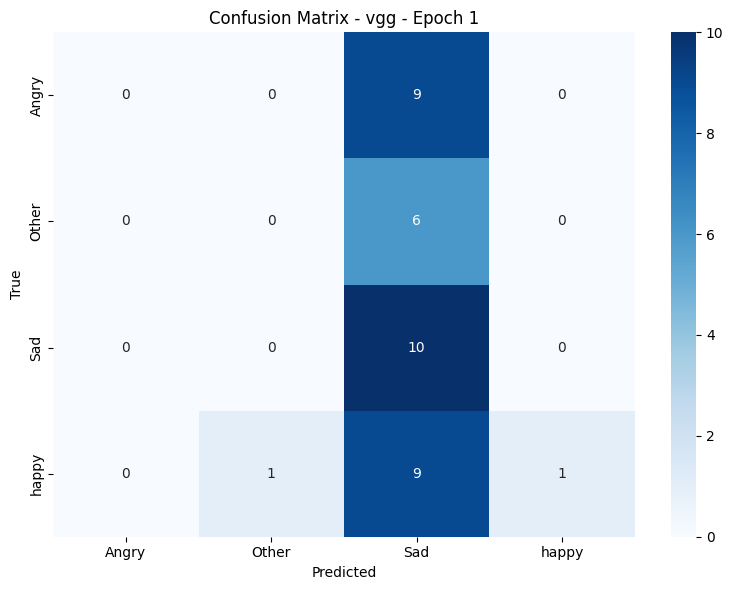

New best model saved (Accuracy: 0.3056)

Epoch [2/10] - Training Loss: 1.4047

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3125    1.0000    0.4762        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.2778        36
   macro avg     0.0781    0.2500    0.1190        36
weighted avg     0.0868    0.2778    0.1323        36


Confusion Matrix:
[[ 0  2  7  0]
 [ 0  0  6  0]
 [ 0  0 10  0]
 [ 0  2  9  0]]


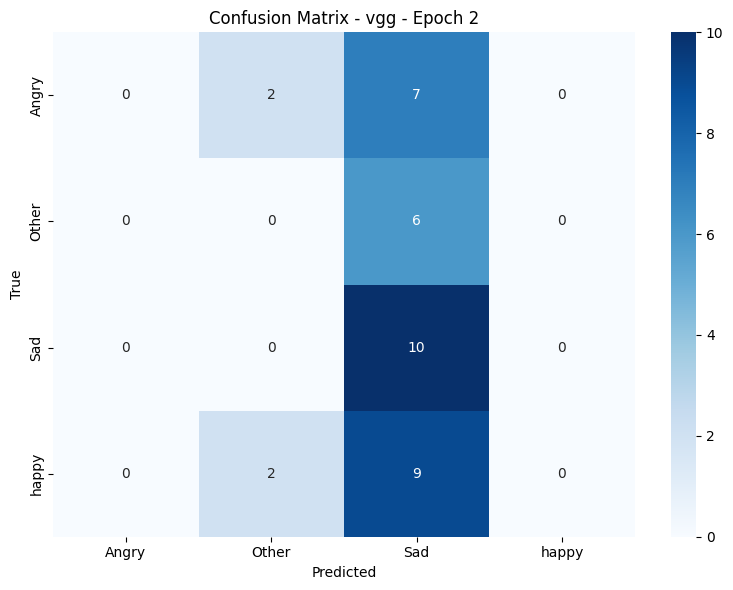


Epoch [3/10] - Training Loss: 1.4034

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    1.0000    0.4000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.2500        36
   macro avg     0.0625    0.2500    0.1000        36
weighted avg     0.0625    0.2500    0.1000        36


Confusion Matrix:
[[ 9  0  0  0]
 [ 6  0  0  0]
 [10  0  0  0]
 [11  0  0  0]]


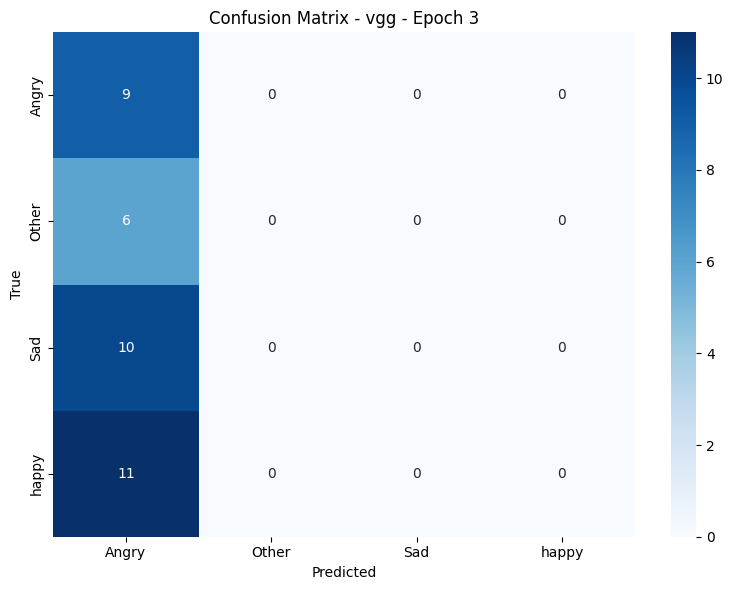


Epoch [4/10] - Training Loss: 1.3979

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.1714    1.0000    0.2927         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.1667        36
   macro avg     0.0429    0.2500    0.0732        36
weighted avg     0.0286    0.1667    0.0488        36


Confusion Matrix:
[[ 0  8  1  0]
 [ 0  6  0  0]
 [ 0 10  0  0]
 [ 0 11  0  0]]


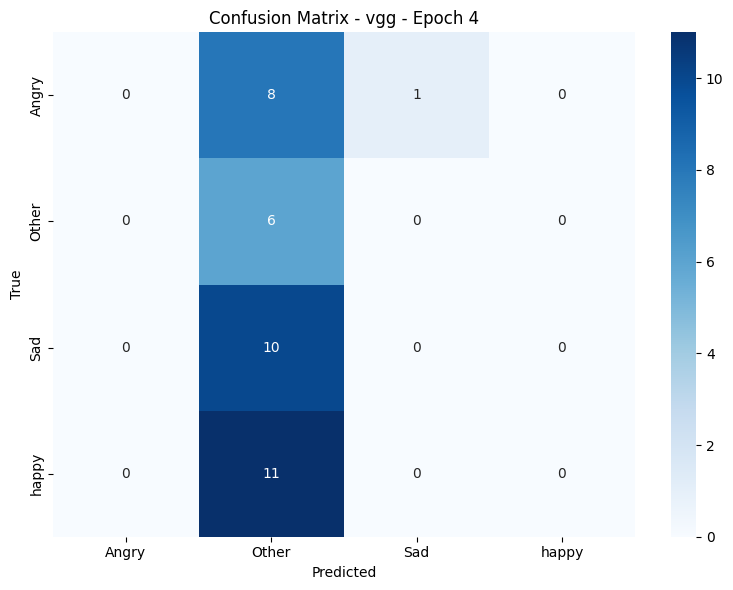


Epoch [5/10] - Training Loss: 1.3974

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.1875    1.0000    0.3158         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.2500    0.0909    0.1333        11

    accuracy                         0.1944        36
   macro avg     0.1094    0.2727    0.1123        36
weighted avg     0.1076    0.1944    0.0934        36


Confusion Matrix:
[[ 0  7  0  2]
 [ 0  6  0  0]
 [ 0  9  0  1]
 [ 0 10  0  1]]


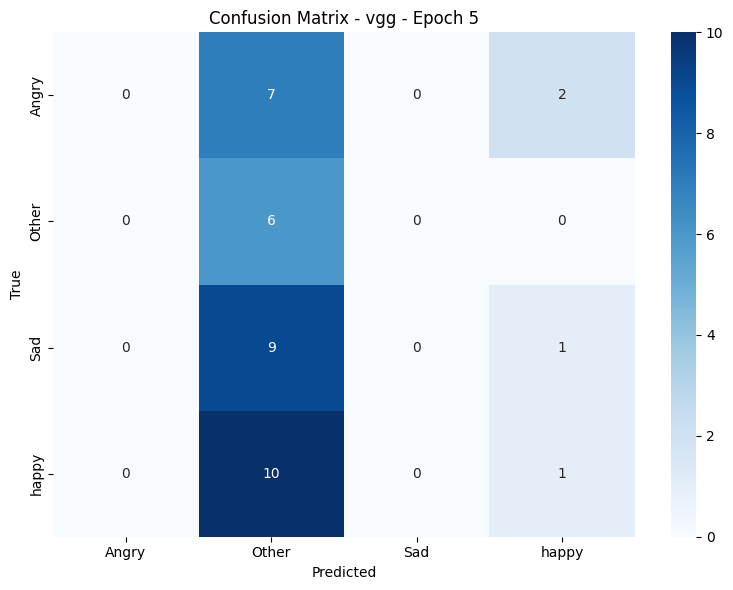


Epoch [6/10] - Training Loss: 1.3843

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2903    0.9000    0.4390        10
       happy     0.5000    0.1818    0.2667        11

    accuracy                         0.3056        36
   macro avg     0.1976    0.2705    0.1764        36
weighted avg     0.2334    0.3056    0.2034        36


Confusion Matrix:
[[0 0 8 1]
 [0 0 6 0]
 [0 0 9 1]
 [0 1 8 2]]


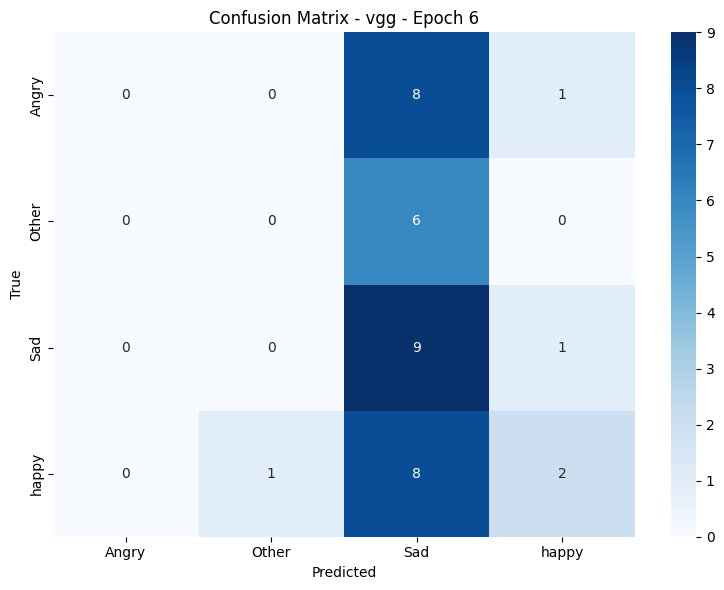


Epoch [7/10] - Training Loss: 1.3742

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2941    1.0000    0.4545        10
       happy     0.5000    0.0909    0.1538        11

    accuracy                         0.3056        36
   macro avg     0.1985    0.2727    0.1521        36
weighted avg     0.2345    0.3056    0.1733        36


Confusion Matrix:
[[ 0  0  8  1]
 [ 0  0  6  0]
 [ 0  0 10  0]
 [ 0  0 10  1]]


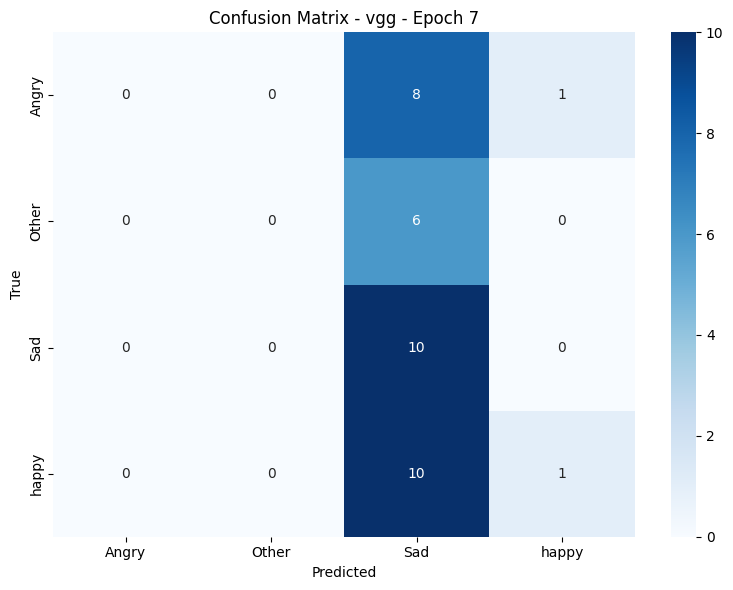


Epoch [8/10] - Training Loss: 1.3697

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2903    0.9000    0.4390        10
       happy     0.6000    0.2727    0.3750        11

    accuracy                         0.3333        36
   macro avg     0.2226    0.2932    0.2035        36
weighted avg     0.2640    0.3333    0.2365        36


Confusion Matrix:
[[0 0 8 1]
 [0 0 6 0]
 [0 0 9 1]
 [0 0 8 3]]


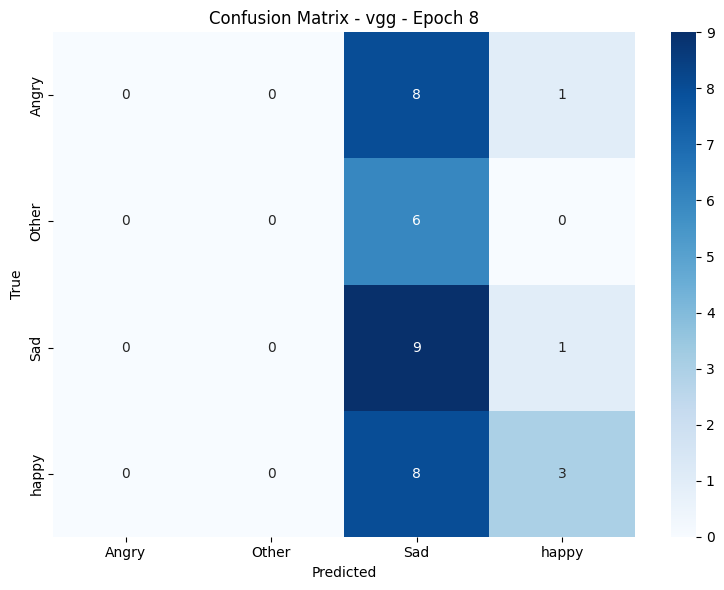

New best model saved (Accuracy: 0.3333)

Epoch [9/10] - Training Loss: 1.3752

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3000    0.9000    0.4500        10
       happy     0.4000    0.1818    0.2500        11

    accuracy                         0.3056        36
   macro avg     0.1750    0.2705    0.1750        36
weighted avg     0.2056    0.3056    0.2014        36


Confusion Matrix:
[[0 0 7 2]
 [0 0 6 0]
 [0 0 9 1]
 [0 1 8 2]]


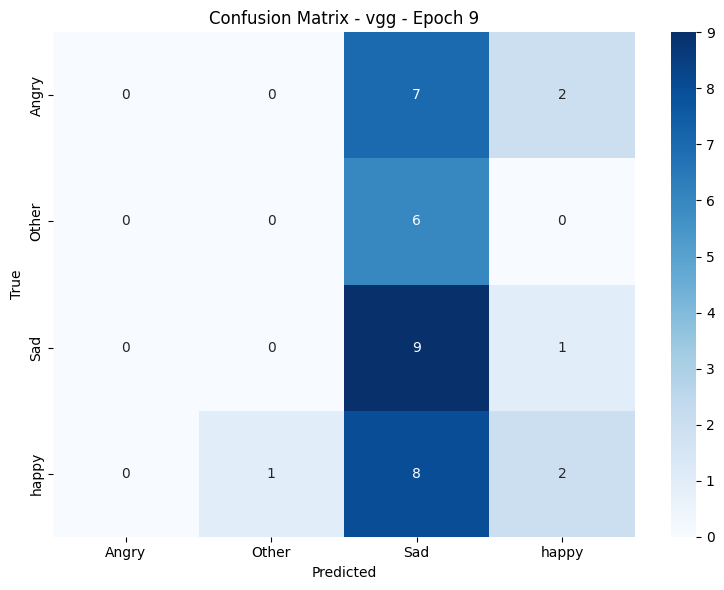


Epoch [10/10] - Training Loss: 1.3698

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    1.0000    0.4444        10
       happy     1.0000    0.0909    0.1667        11

    accuracy                         0.3056        36
   macro avg     0.3214    0.2727    0.1528        36
weighted avg     0.3849    0.3056    0.1744        36


Confusion Matrix:
[[ 0  0  9  0]
 [ 0  0  6  0]
 [ 0  0 10  0]
 [ 0  0 10  1]]


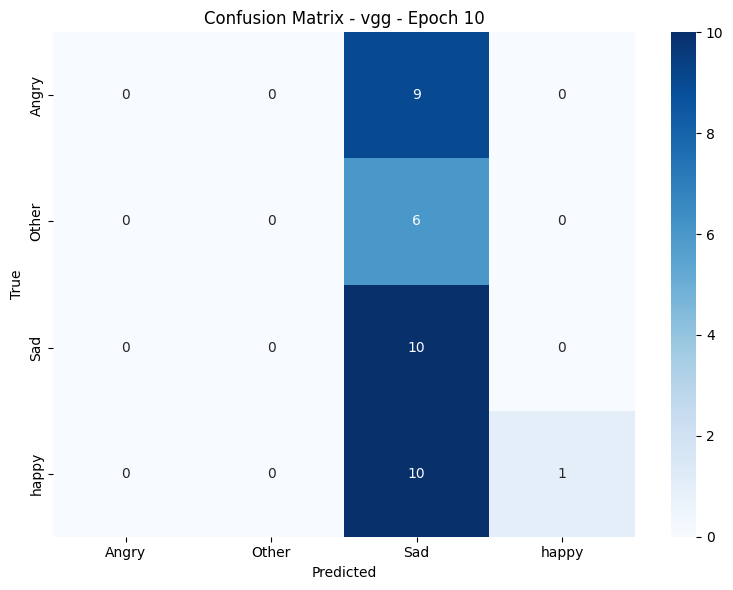

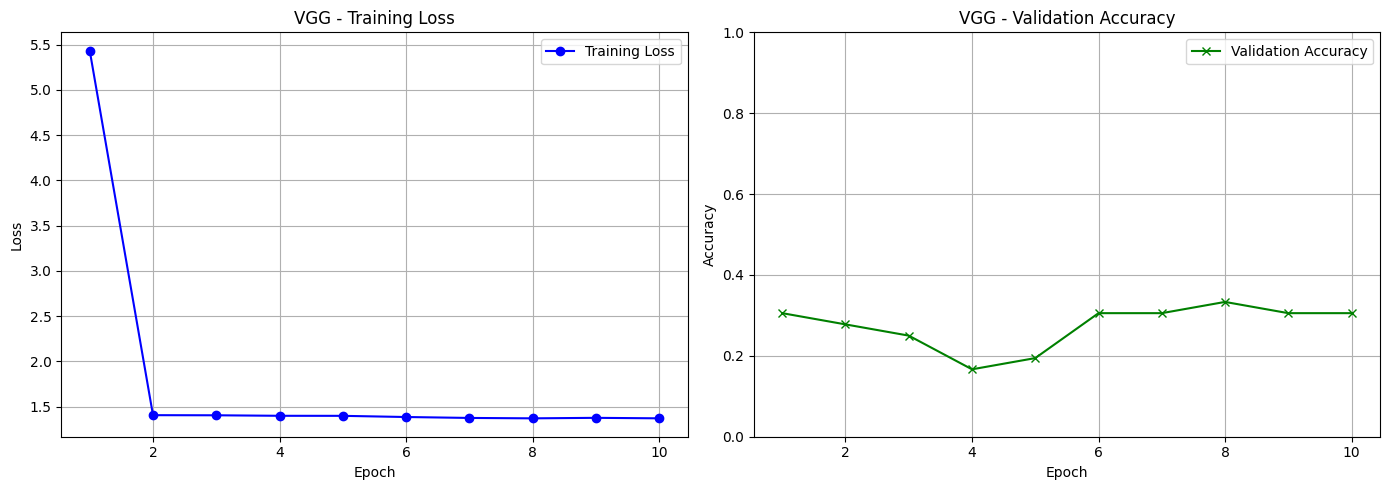


Training complete. Best validation accuracy: 0.3333


==== Training RESNET model ====

Epoch [1/10] - Training Loss: 1.5248

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.4444    0.3200         9
       Other     0.1818    0.3333    0.2353         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5000    0.1818    0.2667        11

    accuracy                         0.2222        36
   macro avg     0.2330    0.2399    0.2055        36
weighted avg     0.2456    0.2222    0.2007        36


Confusion Matrix:
[[4 3 1 1]
 [1 2 3 0]
 [4 5 0 1]
 [7 1 1 2]]


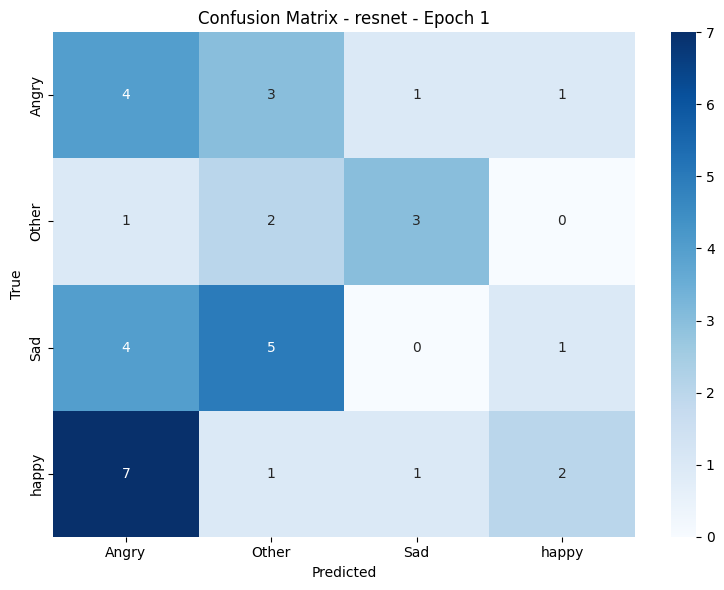

New best model saved (Accuracy: 0.2222)

Epoch [2/10] - Training Loss: 1.3925

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1875    0.3333    0.2400         9
       Other     0.2857    0.3333    0.3077         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.4615    0.5455    0.5000        11

    accuracy                         0.3056        36
   macro avg     0.2337    0.3030    0.2619        36
weighted avg     0.2355    0.3056    0.2641        36


Confusion Matrix:
[[3 3 0 3]
 [2 2 0 2]
 [6 2 0 2]
 [5 0 0 6]]


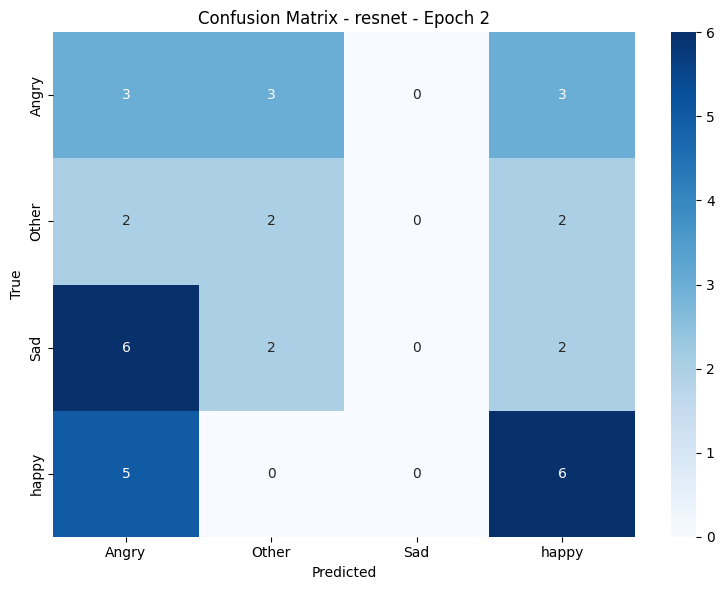

New best model saved (Accuracy: 0.3056)

Epoch [3/10] - Training Loss: 1.3614

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3333    0.6667    0.4444         9
       Other     0.2500    0.5000    0.3333         6
         Sad     0.2500    0.1000    0.1429        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.2778        36
   macro avg     0.2083    0.3167    0.2302        36
weighted avg     0.1944    0.2778    0.2063        36


Confusion Matrix:
[[6 2 1 0]
 [2 3 0 1]
 [3 5 1 1]
 [7 2 2 0]]


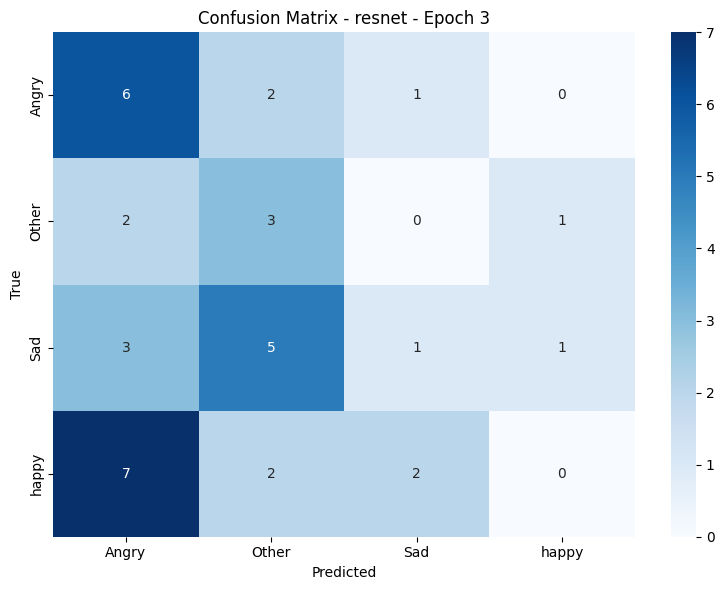


Epoch [4/10] - Training Loss: 1.3239

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3043    0.7778    0.4375         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2500    0.1000    0.1429        10
       happy     0.2500    0.0909    0.1333        11

    accuracy                         0.2500        36
   macro avg     0.2011    0.2422    0.1784        36
weighted avg     0.2219    0.2500    0.1898        36


Confusion Matrix:
[[7 0 0 2]
 [4 0 2 0]
 [6 2 1 1]
 [6 3 1 1]]


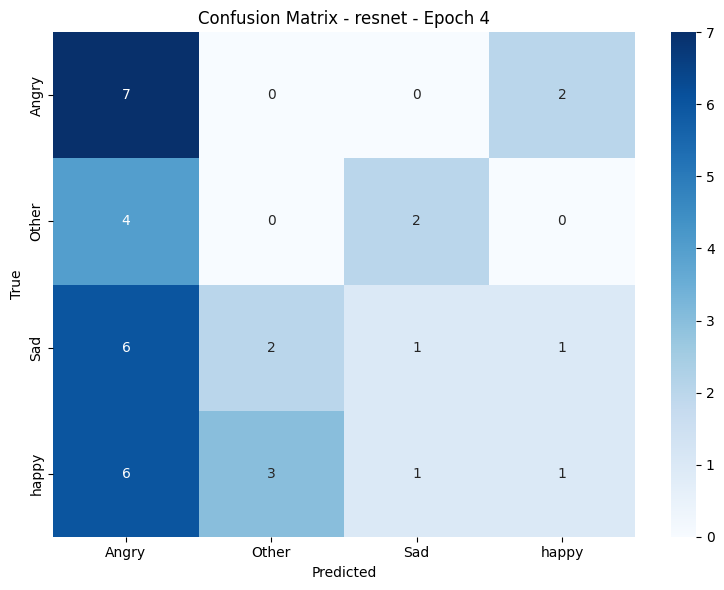


Epoch [5/10] - Training Loss: 1.3315

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3000    0.3333    0.3158         9
       Other     0.2353    0.6667    0.3478         6
         Sad     0.1429    0.1000    0.1176        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.2222        36
   macro avg     0.1695    0.2750    0.1953        36
weighted avg     0.1539    0.2222    0.1696        36


Confusion Matrix:
[[3 2 3 1]
 [1 4 1 0]
 [3 5 1 1]
 [3 6 2 0]]


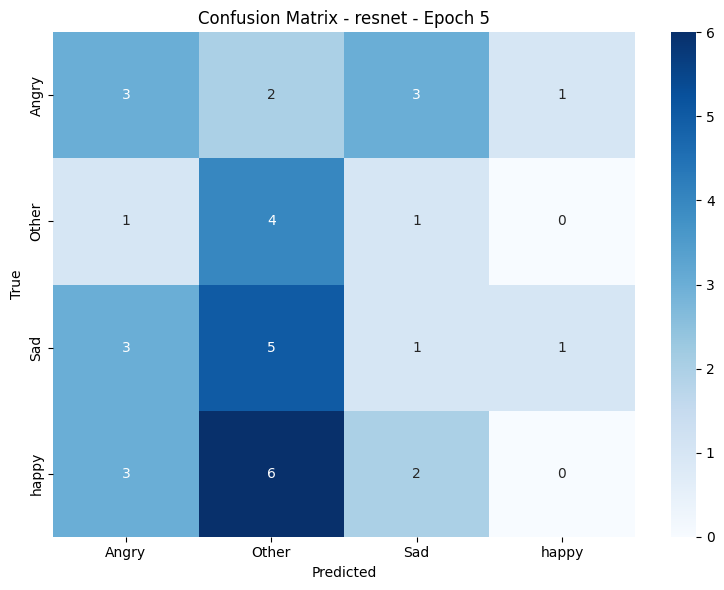


Epoch [6/10] - Training Loss: 1.2612

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1875    0.3333    0.2400         9
       Other     0.1667    0.1667    0.1667         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5000    0.4545    0.4762        11

    accuracy                         0.2500        36
   macro avg     0.2135    0.2386    0.2207        36
weighted avg     0.2274    0.2500    0.2333        36


Confusion Matrix:
[[3 2 2 2]
 [3 1 1 1]
 [5 3 0 2]
 [5 0 1 5]]


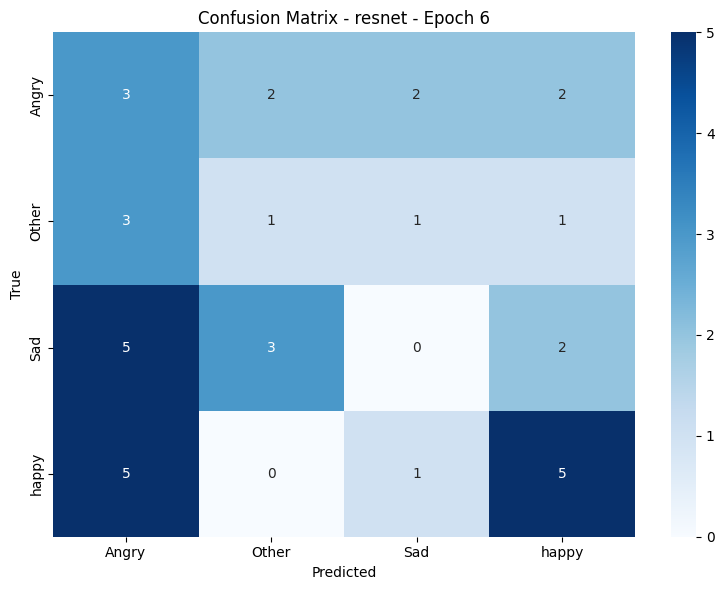


Epoch [7/10] - Training Loss: 1.2372

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2000    0.3333    0.2500         9
       Other     0.2000    0.1667    0.1818         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5000    0.5455    0.5217        11

    accuracy                         0.2778        36
   macro avg     0.2250    0.2614    0.2384        36
weighted avg     0.2361    0.2778    0.2522        36


Confusion Matrix:
[[3 1 2 3]
 [3 1 1 1]
 [5 3 0 2]
 [4 0 1 6]]


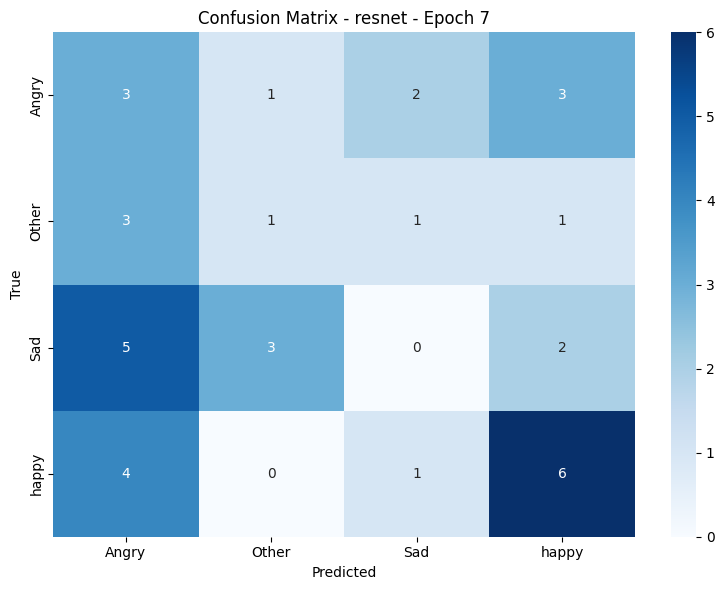


Epoch [8/10] - Training Loss: 1.2194

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1875    0.3333    0.2400         9
       Other     0.2000    0.1667    0.1818         6
         Sad     0.1429    0.1000    0.1176        10
       happy     0.5000    0.3636    0.4211        11

    accuracy                         0.2500        36
   macro avg     0.2576    0.2409    0.2401        36
weighted avg     0.2727    0.2500    0.2516        36


Confusion Matrix:
[[3 0 4 2]
 [3 1 1 1]
 [5 3 1 1]
 [5 1 1 4]]


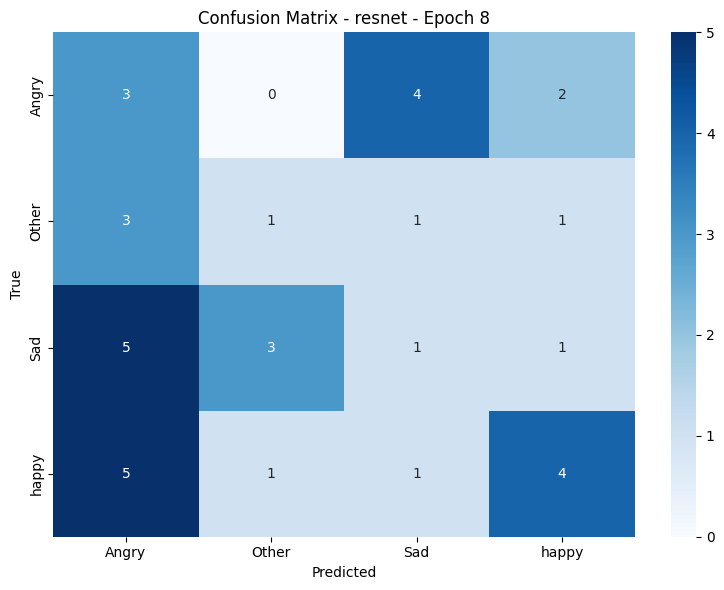


Epoch [9/10] - Training Loss: 1.2107

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2143    0.3333    0.2609         9
       Other     0.2000    0.1667    0.1818         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5000    0.5455    0.5217        11

    accuracy                         0.2778        36
   macro avg     0.2286    0.2614    0.2411        36
weighted avg     0.2397    0.2778    0.2549        36


Confusion Matrix:
[[3 1 2 3]
 [2 1 2 1]
 [5 3 0 2]
 [4 0 1 6]]


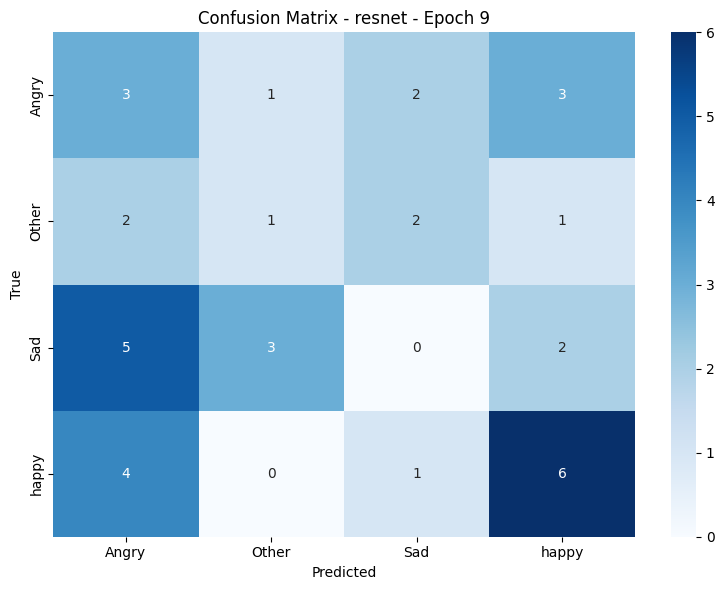


Epoch [10/10] - Training Loss: 1.1915

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.5000    0.5000    0.5000         6
         Sad     0.1429    0.1000    0.1176        10
       happy     0.5455    0.5455    0.5455        11

    accuracy                         0.3611        36
   macro avg     0.3596    0.3697    0.3622        36
weighted avg     0.3522    0.3611    0.3541        36


Confusion Matrix:
[[3 0 3 3]
 [1 3 2 0]
 [4 3 1 2]
 [4 0 1 6]]


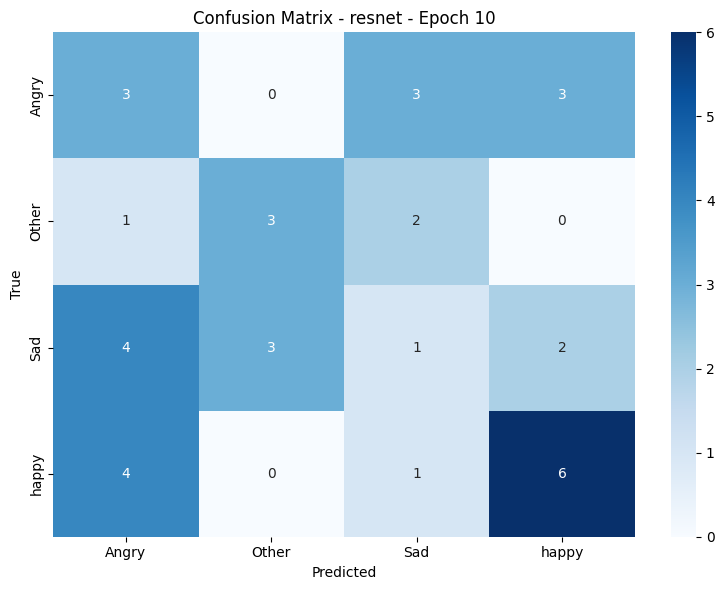

New best model saved (Accuracy: 0.3611)


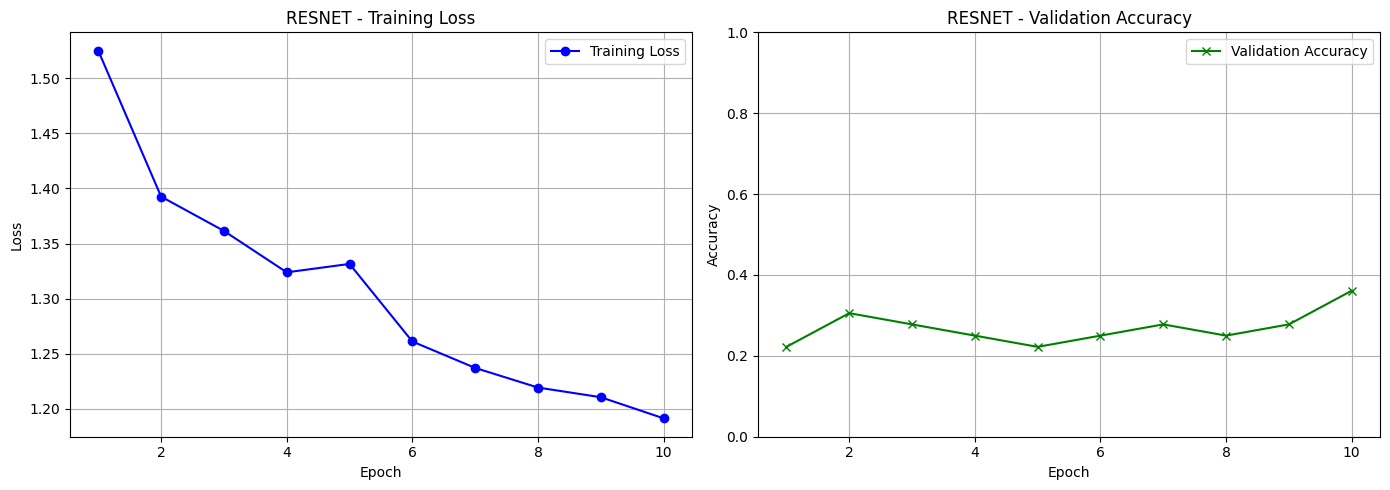


Training complete. Best validation accuracy: 0.3611


==== Training MOBILENET model ====

Epoch [1/10] - Training Loss: 1.3900

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2143    0.3333    0.2609         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2308    0.3000    0.2609        10
       happy     0.5000    0.2727    0.3529        11

    accuracy                         0.2500        36
   macro avg     0.2363    0.2265    0.2187        36
weighted avg     0.2705    0.2500    0.2455        36


Confusion Matrix:
[[3 0 4 2]
 [2 0 3 1]
 [6 1 3 0]
 [3 2 3 3]]


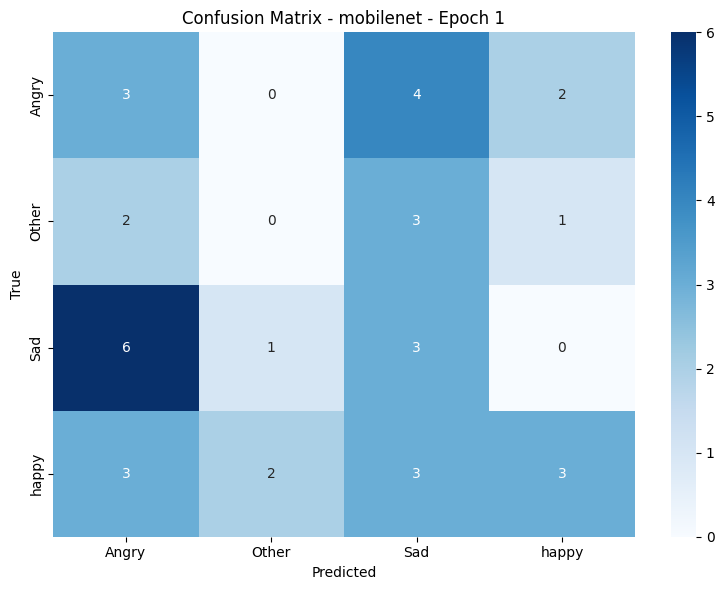

New best model saved (Accuracy: 0.2500)

Epoch [2/10] - Training Loss: 1.3365

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1852    0.5556    0.2778         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3333    0.1000    0.1538        10
       happy     0.2500    0.0909    0.1333        11

    accuracy                         0.1944        36
   macro avg     0.1921    0.1866    0.1412        36
weighted avg     0.2153    0.1944    0.1529        36


Confusion Matrix:
[[5 1 1 2]
 [5 0 1 0]
 [8 0 1 1]
 [9 1 0 1]]


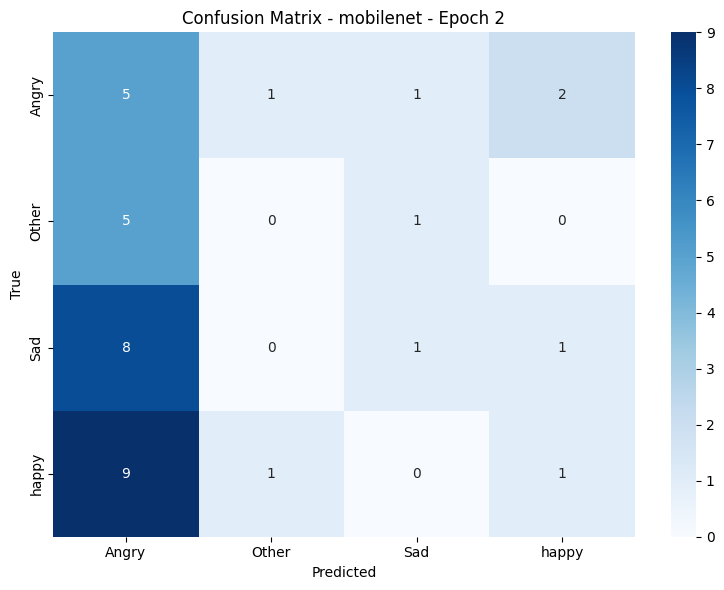


Epoch [3/10] - Training Loss: 1.3159

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1250    0.1111    0.1176         9
       Other     0.1905    0.6667    0.2963         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.4286    0.2727    0.3333        11

    accuracy                         0.2222        36
   macro avg     0.1860    0.2626    0.1868        36
weighted avg     0.1939    0.2222    0.1806        36


Confusion Matrix:
[[1 5 0 3]
 [1 4 0 1]
 [4 6 0 0]
 [2 6 0 3]]


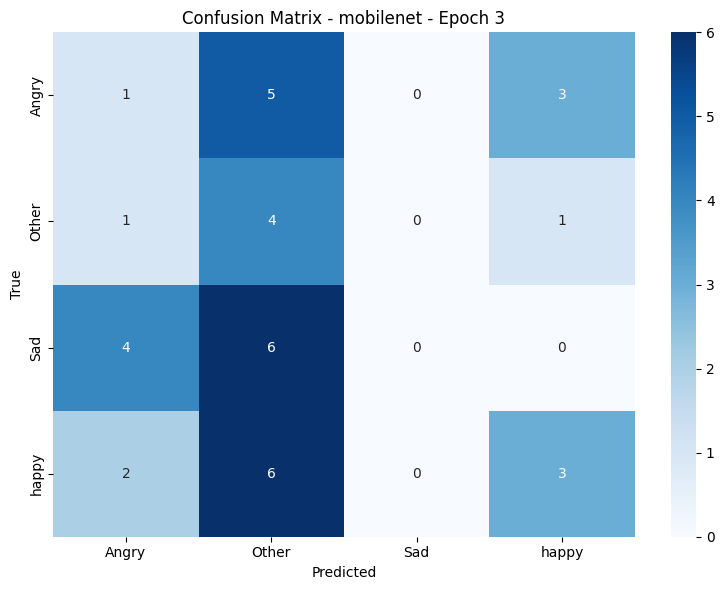


Epoch [4/10] - Training Loss: 1.3086

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.2857    0.3333    0.3077         6
         Sad     0.4286    0.3000    0.3529        10
       happy     0.4444    0.7273    0.5517        11

    accuracy                         0.3611        36
   macro avg     0.2897    0.3402    0.3031        36
weighted avg     0.3025    0.3611    0.3179        36


Confusion Matrix:
[[0 1 3 5]
 [0 2 1 3]
 [3 2 3 2]
 [1 2 0 8]]


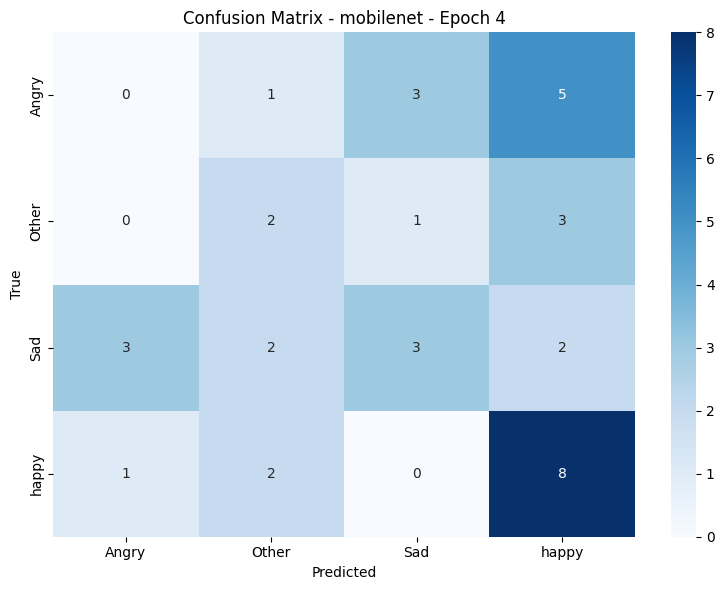

New best model saved (Accuracy: 0.3611)

Epoch [5/10] - Training Loss: 1.2759

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.1111    0.1538         9
       Other     0.2857    0.3333    0.3077         6
         Sad     0.4000    0.2000    0.2667        10
       happy     0.4500    0.8182    0.5806        11

    accuracy                         0.3889        36
   macro avg     0.3464    0.3657    0.3272        36
weighted avg     0.3587    0.3889    0.3412        36


Confusion Matrix:
[[1 1 2 5]
 [0 2 1 3]
 [2 3 2 3]
 [1 1 0 9]]


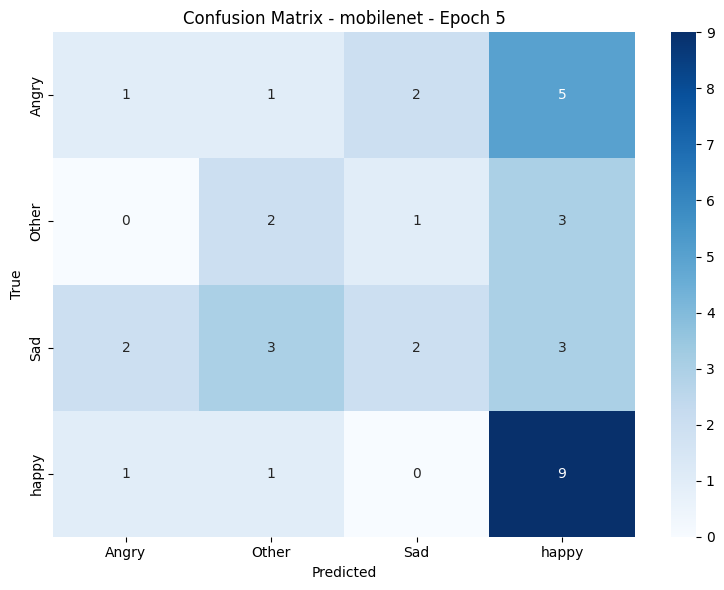

New best model saved (Accuracy: 0.3889)

Epoch [6/10] - Training Loss: 1.2451

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.2500    0.3333    0.2857         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.5000    0.3636    0.4211        11

    accuracy                         0.3056        36
   macro avg     0.3166    0.3076    0.3037        36
weighted avg     0.3315    0.3056    0.3098        36


Confusion Matrix:
[[3 1 2 3]
 [1 2 2 1]
 [5 3 2 0]
 [4 2 1 4]]


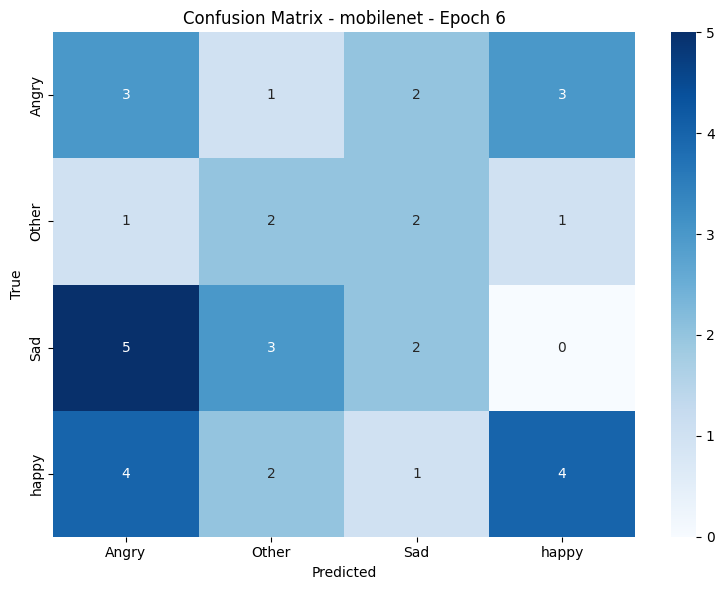


Epoch [7/10] - Training Loss: 1.2105

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.1429    0.1667    0.1538         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.2778        36
   macro avg     0.2696    0.2659    0.2640        36
weighted avg     0.2879    0.2778    0.2788        36


Confusion Matrix:
[[3 1 2 3]
 [1 1 2 2]
 [4 3 2 1]
 [4 2 1 4]]


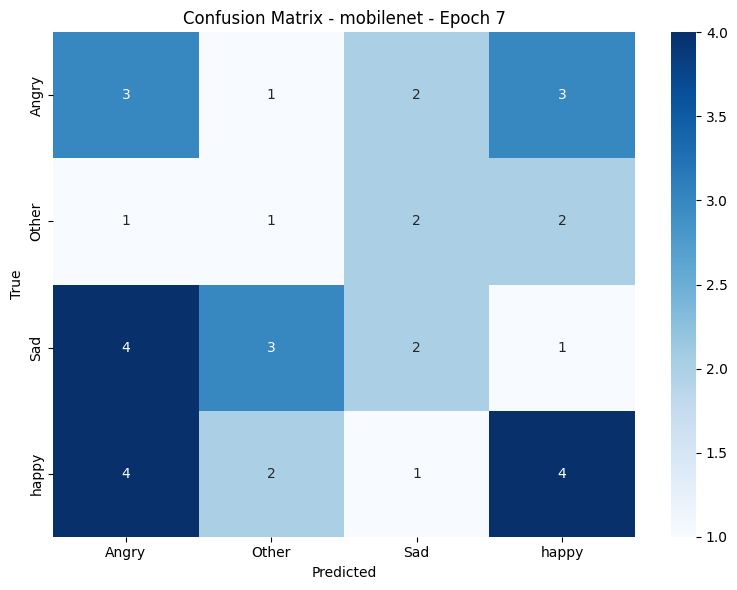


Epoch [8/10] - Training Loss: 1.2012

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.2500        36
   macro avg     0.2291    0.2242    0.2222        36
weighted avg     0.2593    0.2500    0.2499        36


Confusion Matrix:
[[3 1 2 3]
 [2 0 2 2]
 [4 3 2 1]
 [4 2 1 4]]


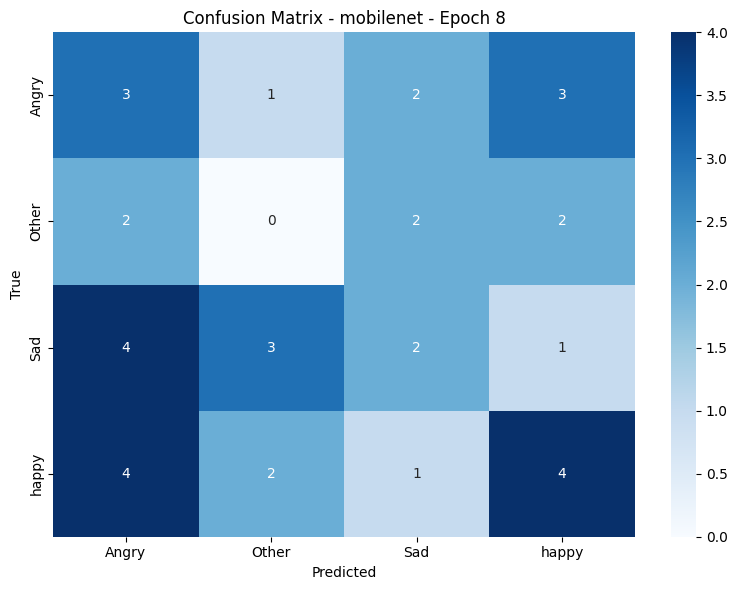


Epoch [9/10] - Training Loss: 1.2041

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.1429    0.1667    0.1538         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.2778        36
   macro avg     0.2696    0.2659    0.2640        36
weighted avg     0.2879    0.2778    0.2788        36


Confusion Matrix:
[[3 1 2 3]
 [1 1 2 2]
 [4 3 2 1]
 [4 2 1 4]]


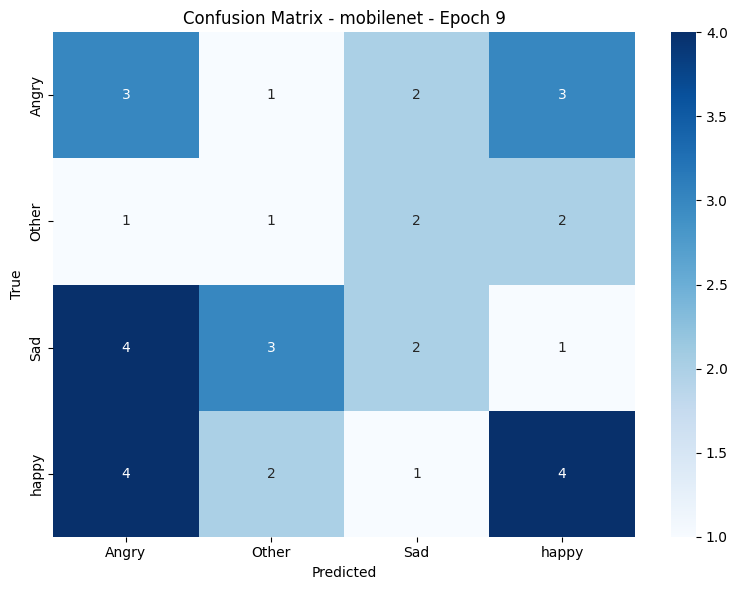


Epoch [10/10] - Training Loss: 1.2094

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.1429    0.1667    0.1538         6
         Sad     0.2500    0.2000    0.2222        10
       happy     0.3333    0.2727    0.3000        11

    accuracy                         0.2500        36
   macro avg     0.2440    0.2432    0.2404        36
weighted avg     0.2576    0.2500    0.2505        36


Confusion Matrix:
[[3 1 2 3]
 [1 1 2 2]
 [4 3 2 1]
 [4 2 2 3]]


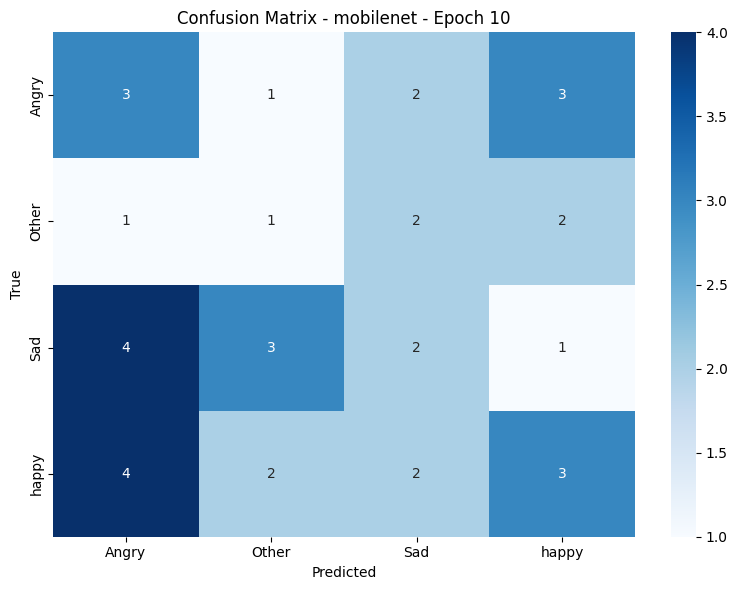

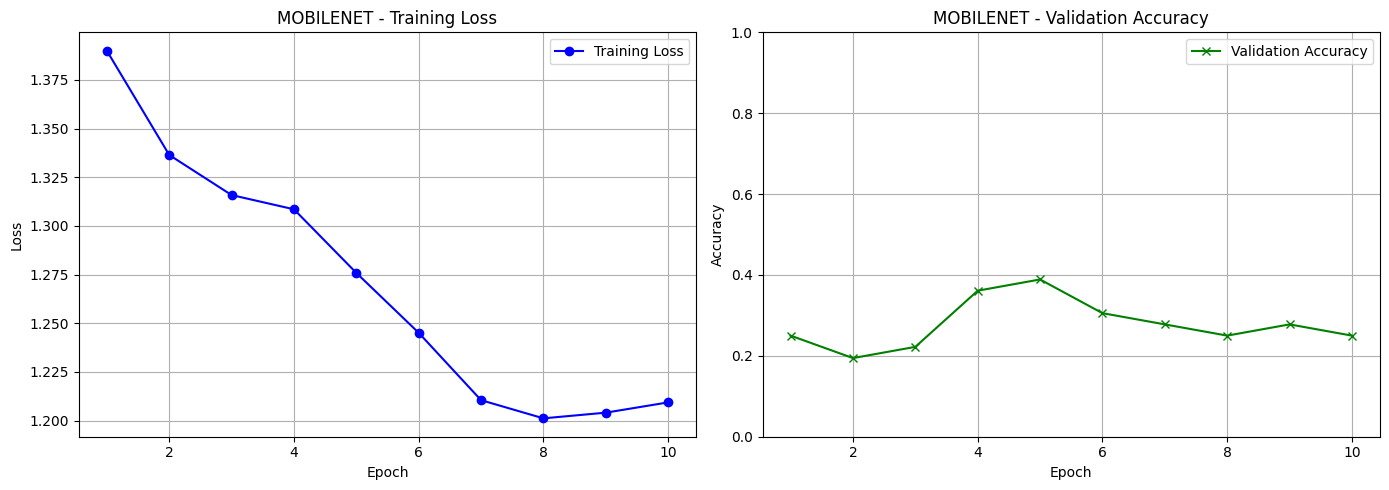


Training complete. Best validation accuracy: 0.3889


==== Training INCEPTION model ====

Epoch [1/10] - Training Loss: 1.4045

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.1667    0.3333    0.2222         6
         Sad     0.5000    0.1000    0.1667        10
       happy     0.4091    0.8182    0.5455        11

    accuracy                         0.3333        36
   macro avg     0.2689    0.3129    0.2336        36
weighted avg     0.2917    0.3333    0.2500        36


Confusion Matrix:
[[0 4 0 5]
 [0 2 1 3]
 [0 4 1 5]
 [0 2 0 9]]


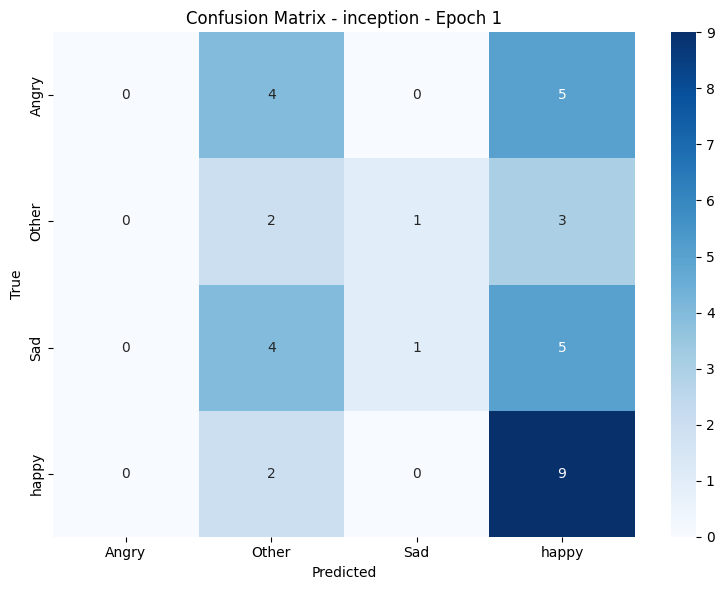

New best model saved (Accuracy: 0.3333)

Epoch [2/10] - Training Loss: 1.3870

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1250    0.1111    0.1176         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.5000    0.4000    0.4444        10
       happy     0.4375    0.6364    0.5185        11

    accuracy                         0.3333        36
   macro avg     0.2656    0.2869    0.2702        36
weighted avg     0.3038    0.3333    0.3113        36


Confusion Matrix:
[[1 0 3 5]
 [2 0 1 3]
 [2 3 4 1]
 [3 1 0 7]]


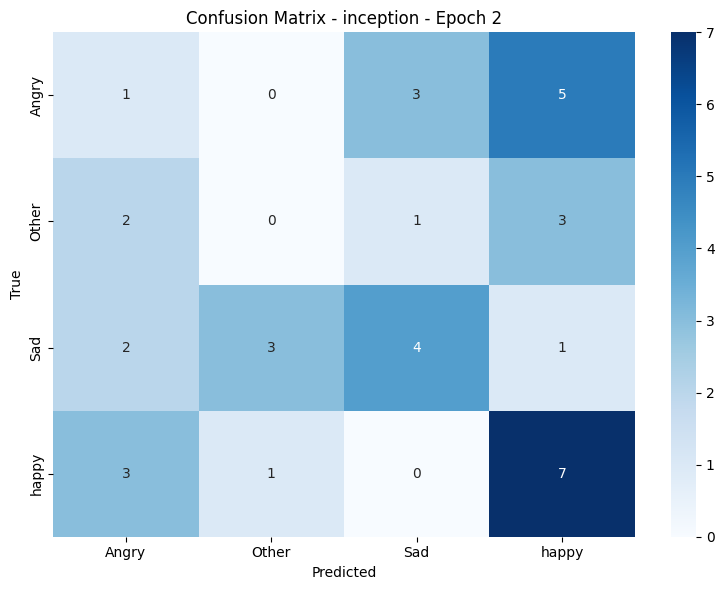


Epoch [3/10] - Training Loss: 1.3896

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.4091    0.8182    0.5455        11

    accuracy                         0.3333        36
   macro avg     0.1600    0.2879    0.2045        36
weighted avg     0.1827    0.3333    0.2348        36


Confusion Matrix:
[[3 0 1 5]
 [4 0 0 2]
 [4 0 0 6]
 [2 0 0 9]]


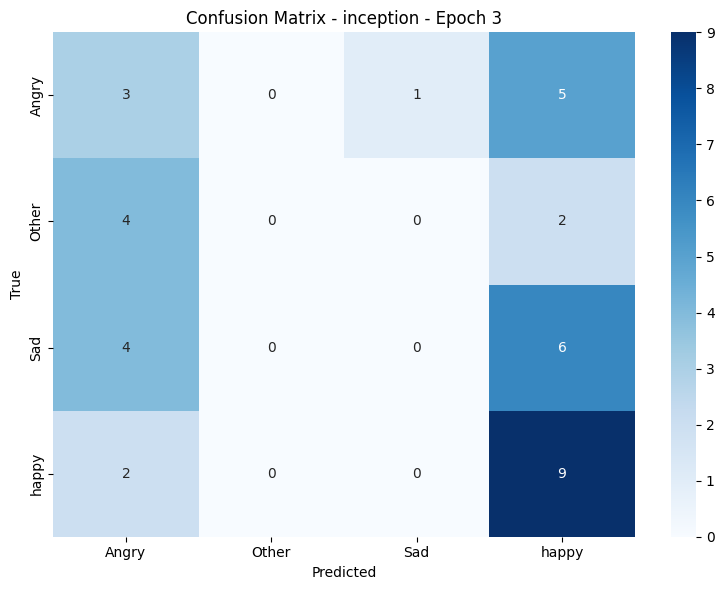


Epoch [4/10] - Training Loss: 1.3836

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2667    0.4444    0.3333         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3750    0.3000    0.3333        10
       happy     0.4545    0.4545    0.4545        11

    accuracy                         0.3333        36
   macro avg     0.2741    0.2997    0.2803        36
weighted avg     0.3097    0.3333    0.3148        36


Confusion Matrix:
[[4 1 3 1]
 [2 0 2 2]
 [4 0 3 3]
 [5 1 0 5]]


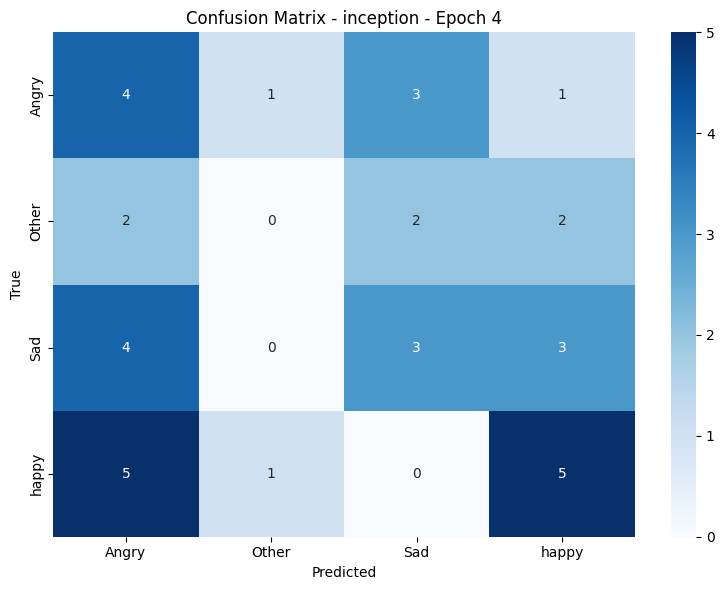


Epoch [5/10] - Training Loss: 1.3848

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2222    0.4444    0.2963         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3333    0.1000    0.1538        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.2500        36
   macro avg     0.2389    0.2270    0.2078        36
weighted avg     0.2704    0.2500    0.2332        36


Confusion Matrix:
[[4 1 1 3]
 [4 0 0 2]
 [6 2 1 1]
 [4 2 1 4]]


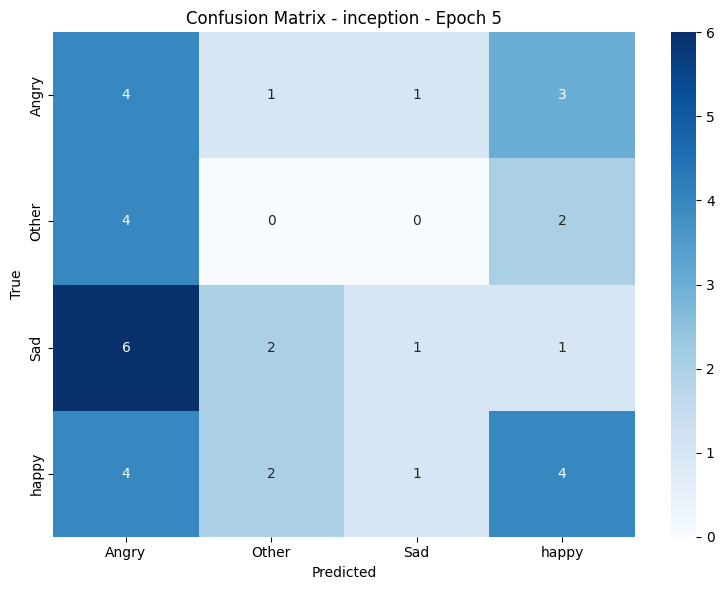


Epoch [6/10] - Training Loss: 1.3763

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.2000    0.2667        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.2778        36
   macro avg     0.2667    0.2470    0.2468        36
weighted avg     0.3009    0.2778    0.2784        36


Confusion Matrix:
[[3 2 1 3]
 [3 0 1 2]
 [4 2 2 2]
 [2 3 1 5]]


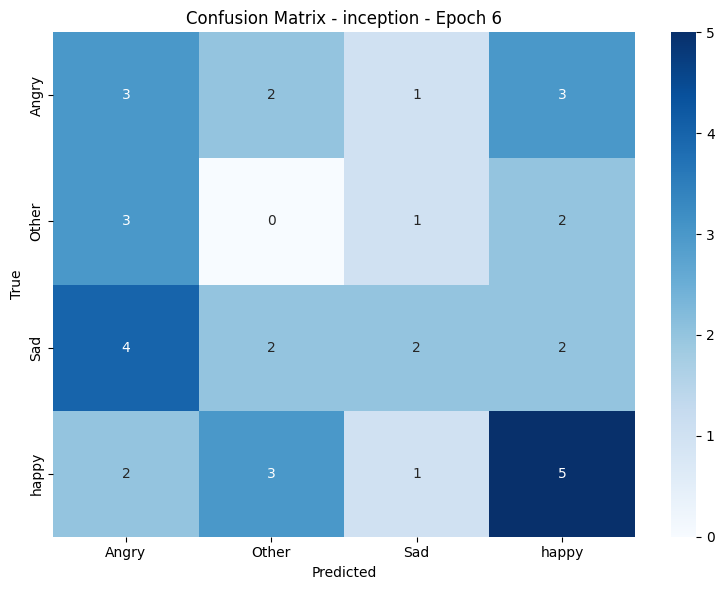


Epoch [7/10] - Training Loss: 1.3747

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2222    0.2222    0.2222         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4444    0.4000    0.4211        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.3056        36
   macro avg     0.2708    0.2692    0.2695        36
weighted avg     0.3063    0.3056    0.3054        36


Confusion Matrix:
[[2 1 3 3]
 [3 0 1 2]
 [2 2 4 2]
 [2 3 1 5]]


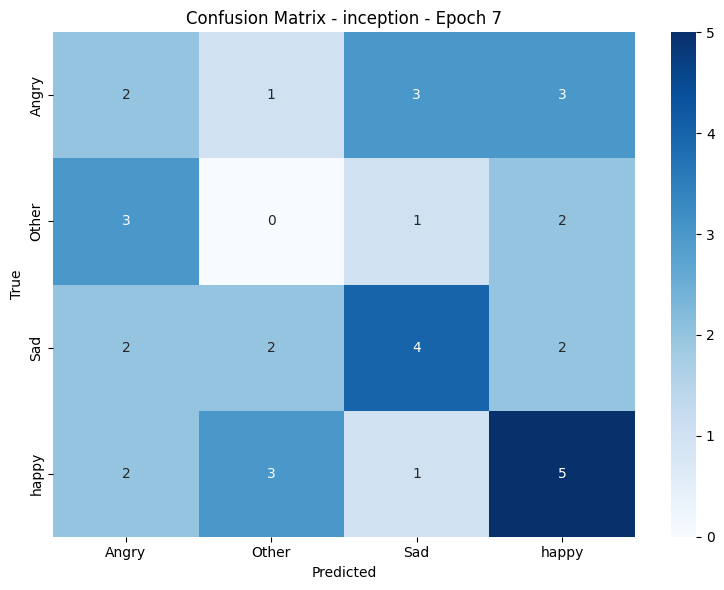


Epoch [8/10] - Training Loss: 1.3749

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2222    0.2222    0.2222         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4444    0.4000    0.4211        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.3056        36
   macro avg     0.2708    0.2692    0.2695        36
weighted avg     0.3063    0.3056    0.3054        36


Confusion Matrix:
[[2 1 3 3]
 [3 0 1 2]
 [2 2 4 2]
 [2 3 1 5]]


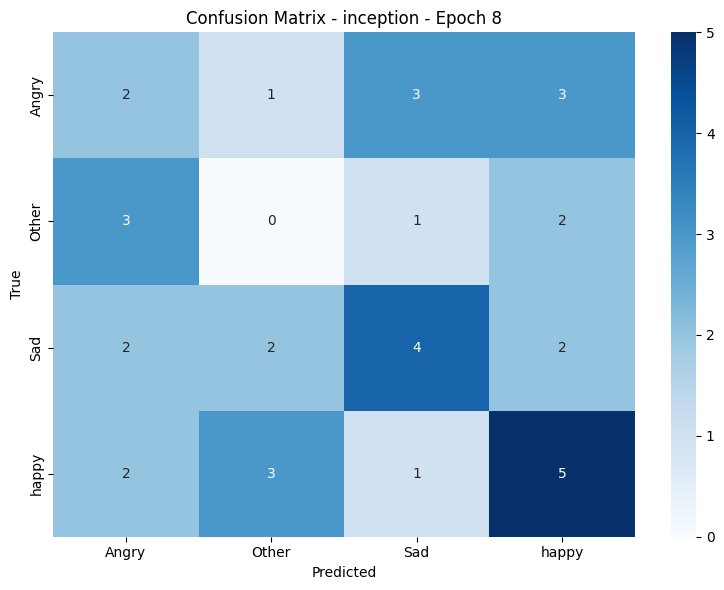


Epoch [9/10] - Training Loss: 1.3740

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1250    0.1111    0.1176         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4444    0.4000    0.4211        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.2778        36
   macro avg     0.2465    0.2414    0.2434        36
weighted avg     0.2820    0.2778    0.2792        36


Confusion Matrix:
[[1 2 3 3]
 [3 0 1 2]
 [2 2 4 2]
 [2 3 1 5]]


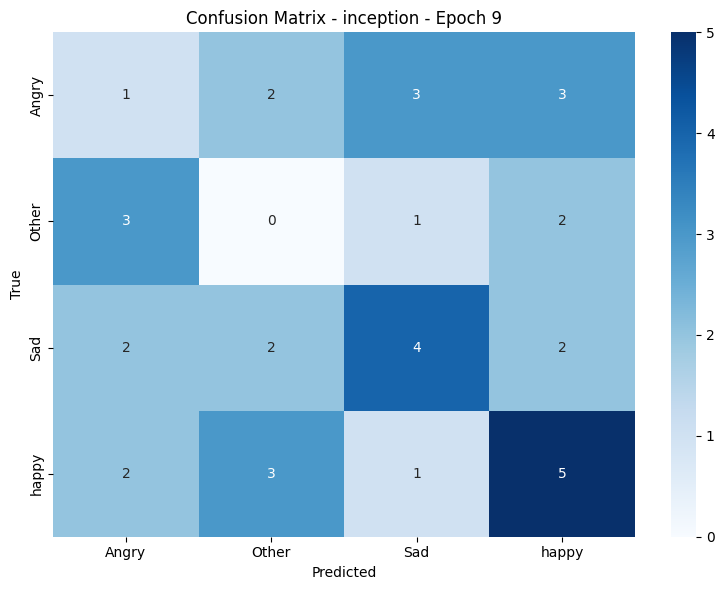


Epoch [10/10] - Training Loss: 1.3742

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1250    0.1111    0.1176         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4444    0.4000    0.4211        10
       happy     0.4545    0.4545    0.4545        11

    accuracy                         0.2778        36
   macro avg     0.2560    0.2414    0.2483        36
weighted avg     0.2936    0.2778    0.2853        36


Confusion Matrix:
[[1 2 3 3]
 [3 0 1 2]
 [2 3 4 1]
 [2 3 1 5]]


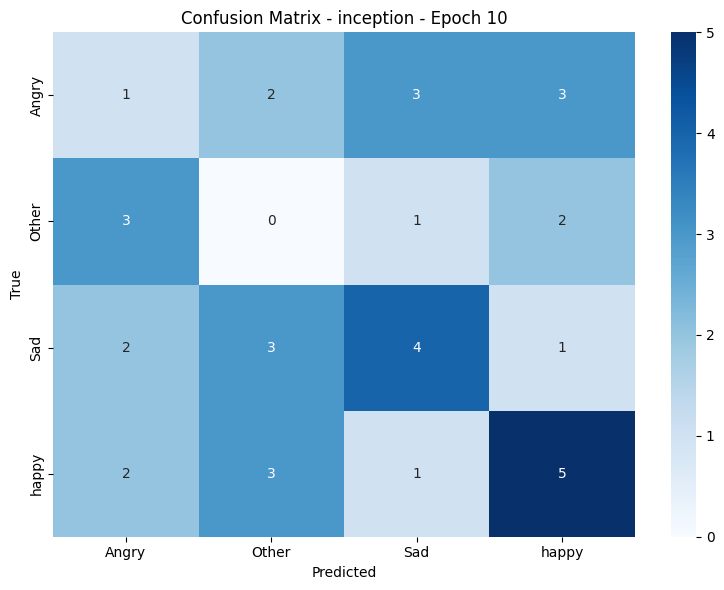

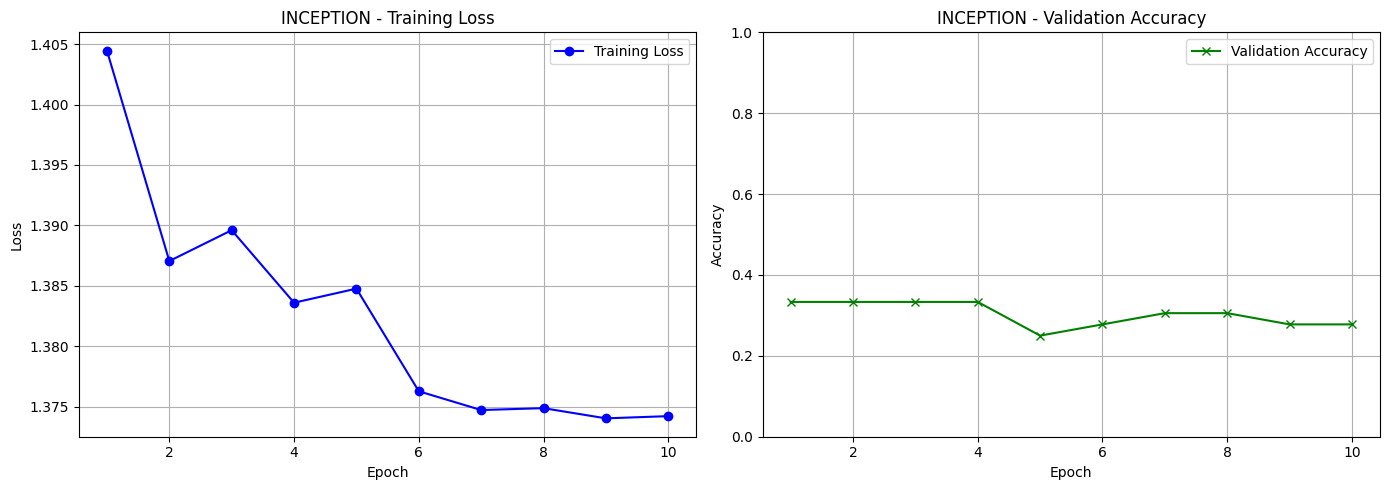


Training complete. Best validation accuracy: 0.3333


==== Training DENSENET model ====

Epoch [1/10] - Training Loss: 1.4071

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3000    0.6000    0.4000        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.2500        36
   macro avg     0.1375    0.2333    0.1714        36
weighted avg     0.1458    0.2500    0.1825        36


Confusion Matrix:
[[3 0 6 0]
 [3 0 3 0]
 [2 2 6 0]
 [4 2 5 0]]


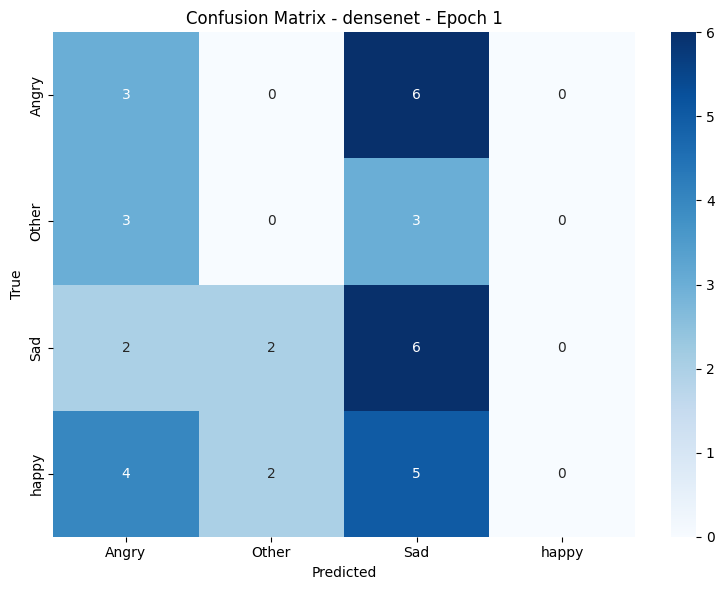

New best model saved (Accuracy: 0.2500)

Epoch [2/10] - Training Loss: 1.3990

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.4000    0.3333    0.3636         6
         Sad     0.3333    0.2000    0.2500        10
       happy     0.3600    0.8182    0.5000        11

    accuracy                         0.3611        36
   macro avg     0.2733    0.3379    0.2784        36
weighted avg     0.2693    0.3611    0.2828        36


Confusion Matrix:
[[0 2 2 5]
 [0 2 1 3]
 [0 0 2 8]
 [0 1 1 9]]


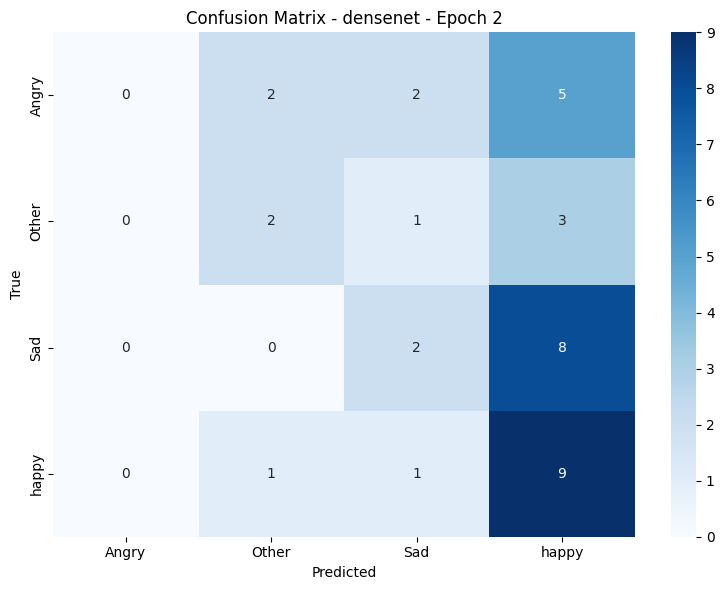

New best model saved (Accuracy: 0.3611)

Epoch [3/10] - Training Loss: 1.3847

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     1.0000    0.1111    0.2000         9
       Other     0.2500    0.5000    0.3333         6
         Sad     0.4167    0.5000    0.4545        10
       happy     0.4545    0.4545    0.4545        11

    accuracy                         0.3889        36
   macro avg     0.5303    0.3914    0.3606        36
weighted avg     0.5463    0.3889    0.3707        36


Confusion Matrix:
[[1 1 4 3]
 [0 3 2 1]
 [0 3 5 2]
 [0 5 1 5]]


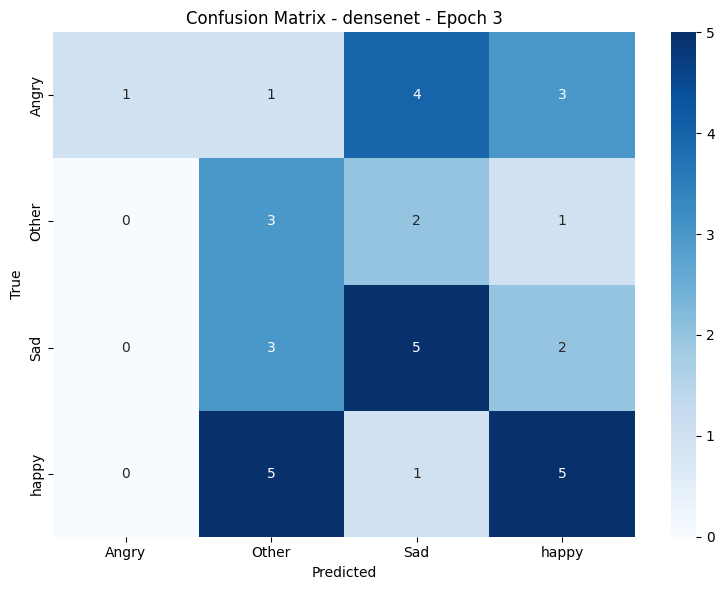

New best model saved (Accuracy: 0.3889)

Epoch [4/10] - Training Loss: 1.3908

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2667    0.4000    0.3200        10
       happy     0.7500    0.2727    0.4000        11

    accuracy                         0.2778        36
   macro avg     0.3119    0.2515    0.2482        36
weighted avg     0.3609    0.2778    0.2793        36


Confusion Matrix:
[[3 1 4 1]
 [3 0 3 0]
 [5 1 4 0]
 [2 2 4 3]]


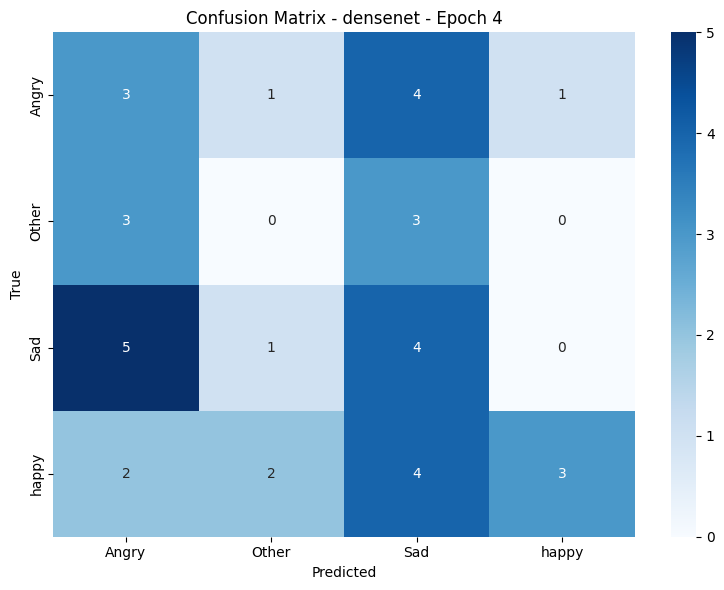


Epoch [5/10] - Training Loss: 1.3746

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.1250    0.1667    0.1429         6
         Sad     0.3333    0.5000    0.4000        10
       happy     0.5000    0.5455    0.5217        11

    accuracy                         0.3333        36
   macro avg     0.2396    0.3030    0.2661        36
weighted avg     0.2662    0.3333    0.2943        36


Confusion Matrix:
[[0 1 4 4]
 [0 1 4 1]
 [1 3 5 1]
 [0 3 2 6]]


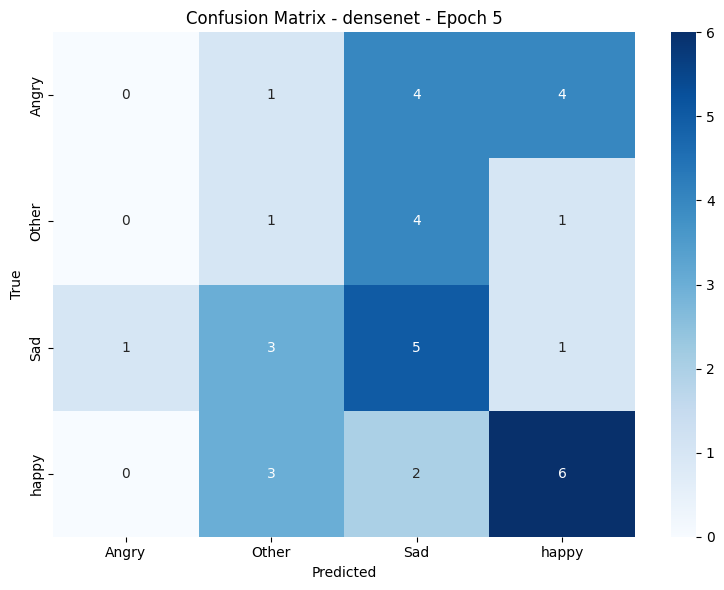


Epoch [6/10] - Training Loss: 1.3671

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.1538    0.3333    0.2105         6
         Sad     0.3333    0.3000    0.3158        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.2500        36
   macro avg     0.2218    0.2492    0.2268        36
weighted avg     0.2405    0.2500    0.2392        36


Confusion Matrix:
[[0 3 2 4]
 [1 2 2 1]
 [3 3 3 1]
 [0 5 2 4]]


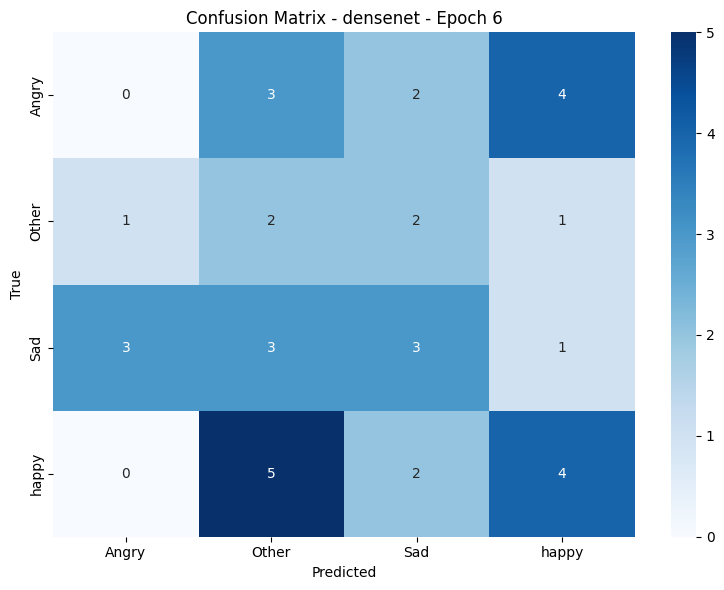


Epoch [7/10] - Training Loss: 1.3582

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.1667    0.3333    0.2222         6
         Sad     0.3333    0.3000    0.3158        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.2500        36
   macro avg     0.2250    0.2492    0.2297        36
weighted avg     0.2426    0.2500    0.2412        36


Confusion Matrix:
[[0 3 2 4]
 [1 2 2 1]
 [3 3 3 1]
 [1 4 2 4]]


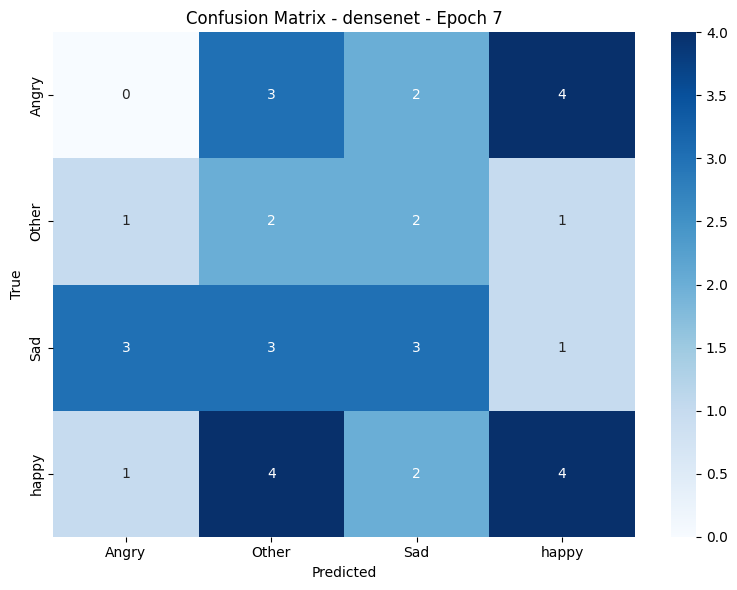


Epoch [8/10] - Training Loss: 1.3532

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0909    0.1667    0.1176         6
         Sad     0.3333    0.3000    0.3158        10
       happy     0.4444    0.3636    0.4000        11

    accuracy                         0.2222        36
   macro avg     0.2172    0.2076    0.2084        36
weighted avg     0.2435    0.2222    0.2295        36


Confusion Matrix:
[[0 3 2 4]
 [2 1 2 1]
 [4 3 3 0]
 [1 4 2 4]]


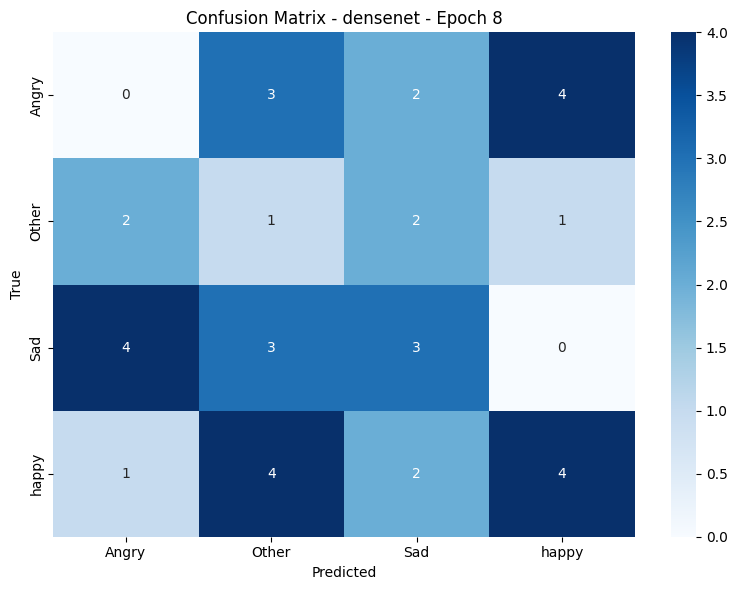


Epoch [9/10] - Training Loss: 1.3572

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1111    0.1111    0.1111         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3750    0.3000    0.3333        10
       happy     0.4444    0.3636    0.4000        11

    accuracy                         0.2222        36
   macro avg     0.2326    0.1937    0.2111        36
weighted avg     0.2677    0.2222    0.2426        36


Confusion Matrix:
[[1 3 1 4]
 [3 0 2 1]
 [4 3 3 0]
 [1 4 2 4]]


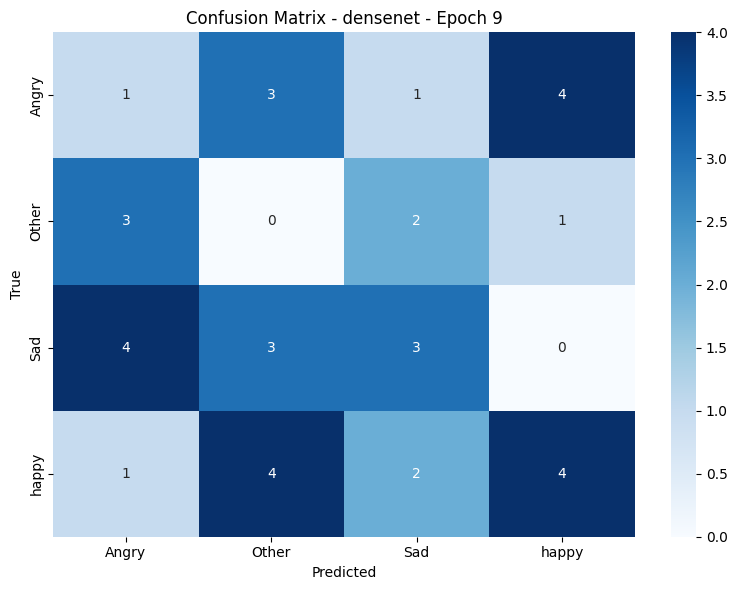


Epoch [10/10] - Training Loss: 1.3542

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3333    0.3000    0.3158        10
       happy     0.4444    0.3636    0.4000        11

    accuracy                         0.1944        36
   macro avg     0.1944    0.1659    0.1789        36
weighted avg     0.2284    0.1944    0.2099        36


Confusion Matrix:
[[0 3 2 4]
 [3 0 2 1]
 [4 3 3 0]
 [1 4 2 4]]


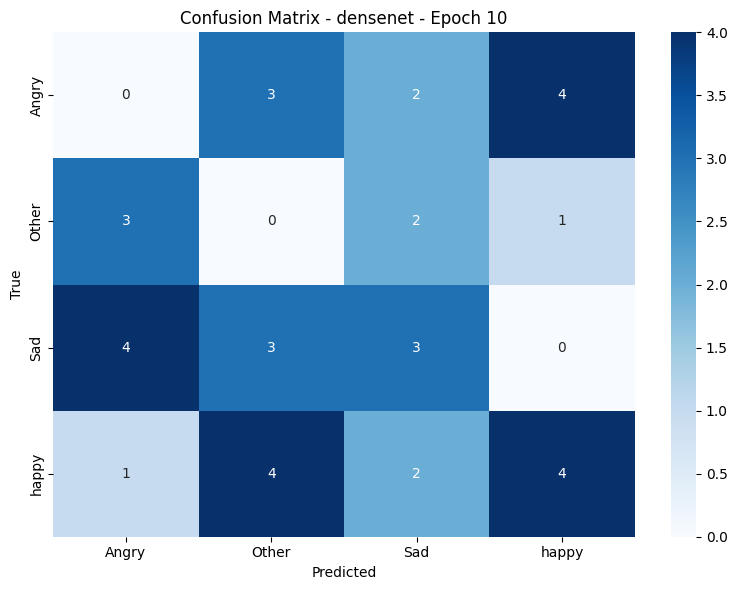

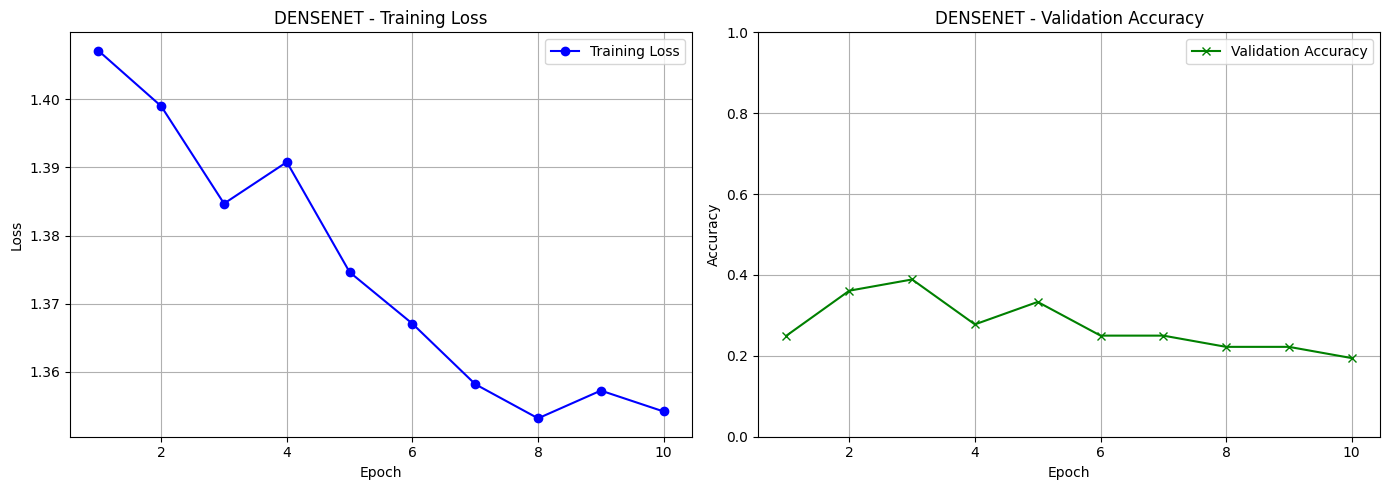


Training complete. Best validation accuracy: 0.3889


 Best model is: MOBILENET with Accuracy = 0.3889


In [5]:
results = {}
best_model_name = None
best_accuracy = 0.0

for name, model_class in model_map.items():
    acc = train_and_evaluate_model(
        model_name=name,
        model_class=model_class,
        num_classes=num_classes,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        epochs=10,
        lr=1e-3
    )
    results[name] = acc
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name

print(f"\n Best model is: {best_model_name.upper()} with Accuracy = {best_accuracy:.4f}")
with open("best_models_log.txt", "a") as log_file:
        log_file.write(f"{best_model_name},{best_accuracy:.4f}\n")

Among the tested architectures (VGG, ResNet, MobileNet, Inception, DenseNet) MobileNet achieved the highest validation accuracy  indicating it was the most effective model 
Why MobileNet Performed Best:
Lightweight and Efficient: MobileNet uses depthwise separable convolutions, reducing computation while preserving accuracy
Generalization: It likely generalizes better on this dataset due to its balanced architecture
Fewer Parameters: Lower risk of overfitting, especially important for smaller or medium-sized datasets

Training Loss Curve:
A decreasing trend suggests the model is learning effectively.
A plateau or spike could indicate underfitting or overfitting.
Validation Accuracy Curve:
An upward trend means better performance on unseen data.
If it diverges from training accuracy, it may signal overfitting.

Confusion Matrix:
Diagonal dominance indicates correct classification.
Off-diagonal values show misclassifications between specific classes.